In [1]:
import pandas as pd
#Google colab does not have pickle
try:
  import pickle5 as pickle
except:
  !pip install pickle5
  import pickle5 as pickle
import os
import seaborn as sns
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D,Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding,  Concatenate, Lambda
from keras.models import Model
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve, auc
from numpy import random
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_Data/')
import functions as f

     |████████████████████████████████| 133kB 13.0MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219245 sha256=5fa2d223889f41677cf6e1acbf26e9385df5ace3f62dbb7aa942302482a9513c
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:
def load_data(D=1,randomize=False):
    try:
        with open('/content/drive/MyDrive/ML_Data/df_train_'+str(D)+'D.pickle', 'rb') as handle:
            df_train = pickle.load(handle)
    except:
        df_train = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-train.pkl")
    try:
        with open('/content/drive/MyDrive/ML_Data/df_test_'+str(D)+'D.pickle', 'rb') as handle:
            df_test = pickle.load(handle)
    except:
        df_test = pd.read_pickle("C:/Users/nik00/py/proj/hyppi-independent.pkl")
    if randomize:
        return shuff_together(df_train,df_test)
    else:
        return df_train,df_test

df_train,df_test = load_data(5)
print('The data used will be:')
df_train[['Human','Yersinia']]

The data used will be:


,Human,Yersinia
0,"[MKDKQ, KDKQK, DKQKK, KQKKK, QKKKK, KKKKE, KKK...","[MAKAS, AKASR, KASRH, ASRHN, SRHNL, RHNLS, HNL..."
1,"[MSWSG, SWSGL, WSGLL, SGLLH, GLLHG, LLHGL, LHG...","[MQHVT, QHVTG, HVTGS, VTGSK, TGSKR, GSKRR, SKR..."
2,"[MSLFD, SLFDL, LFDLF, FDLFR, DLFRG, LFRGF, FRG...","[MAELP, AELPA, ELPAK, LPAKR, PAKRR, AKRRF, KRR..."
3,"[MAVAP, AVAPR, VAPRL, APRLF, PRLFG, RLFGG, LFG...","[MRIFA, RIFAI, IFAIS, FAISC, AISCS, ISCSS, SCS..."
4,"[MSTIQ, STIQS, TIQSE, IQSET, QSETD, SETDC, ETD...","[MSYAF, SYAFP, YAFPG, AFPGT, FPGTF, PGTFP, GTF..."
...,...,...
6265,"[MSYFG, SYFGE, YFGEH, FGEHF, GEHFW, EHFWG, HFW...","[MITTD, ITTDG, TTDGN, TDGNS, DGNSA, GNSAV, NSA..."
6266,"[MTVGK, TVGKS, VGKSS, GKSSK, KSSKM, SSKML, SKM...","[MSQPP, SQPPF, QPPFW, PPFWQ, PFWQQ, FWQQK, WQQ..."
6267,"[MNNLS, NNLSF, NLSFS, LSFSE, SFSEL, FSELC, SEL...","[MSEDR, SEDRH, EDRHQ, DRHQQ, RHQQR, HQQRQ, QQR..."
6268,"[MAPEI, APEIN, PEINL, EINLP, INLPG, NLPGP, LPG...","[MKNLS, KNLSF, NLSFV, LSFVA, SFVAG, FVAGL, VAG..."


Median length of Human sequence is 475


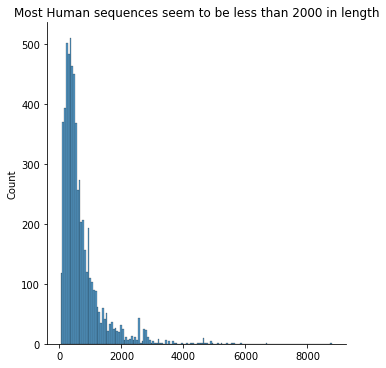

In [ ]:
lengths = sorted(len(s) for s in df_train['Human'])
print("Median length of Human sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Human sequences seem to be less than 2000 in length")

Median length of Yersinia sequence is 332


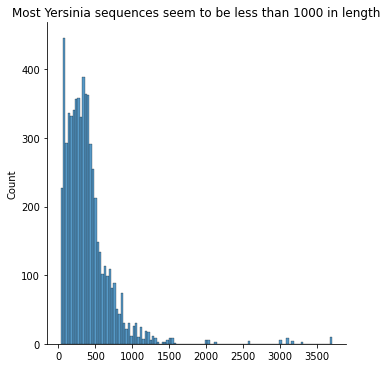

In [ ]:
lengths = sorted(len(s) for s in df_train['Yersinia'])
print("Median length of Yersinia sequence is",lengths[len(lengths)//2])
_  = sns.displot(lengths)
_=plt.title("Most Yersinia sequences seem to be less than 1000 in length")

MAX_VOCAB_SIZE is 500000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 5301
min sequences1_train length: 12
median sequences1_train length: 327


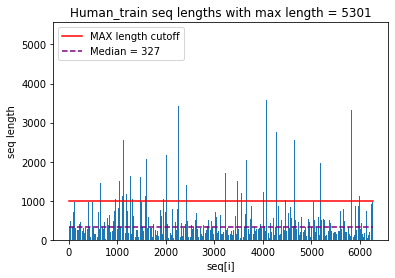

max word index sequences1_train: 499999
max sequences2_train length: 3706
min sequences2_train length: 9
median sequences2_train length: 307


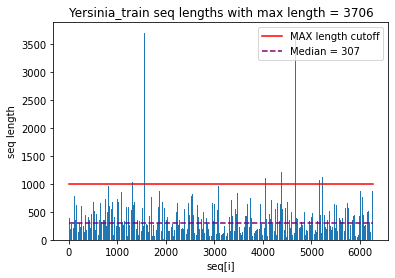

max word index sequences2_train: 499999
Found 1330540 unique tokens in tokenizer1.
Found 639136 unique tokens in tokenizer2.
pre padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 4674
min test_sequences1 length: 10
median test_sequences1 length: 271


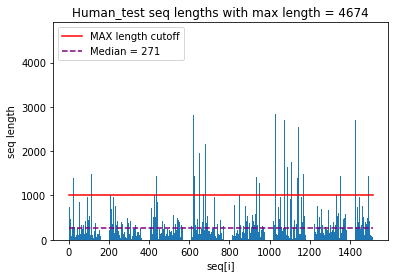

max test_sequences2 length: 3706
min test_sequences2 length: 5
median test_sequences2 length: 244


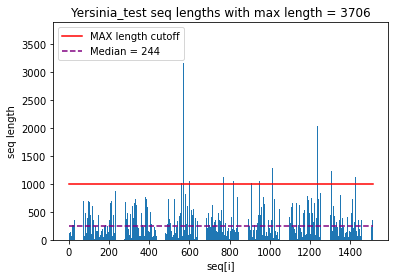

pre padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 500000


In [3]:
data1_5D_doubleip_pre,data2_5D_doubleip_pre,data1_test_5D_doubleip_pre,data2_test_5D_doubleip_pre,num_words_5D,MAX_SEQUENCE_LENGTH_5D,MAX_VOCAB_SIZE_5D = f.get_seq_data_doubleip(500000,1000,df_train,df_test,pad = 'pre',show = True)

In [ ]:
data1_5D_doubleip_center,data2_5D_doubleip_center,data1_test_5D_doubleip_center,data2_test_5D_doubleip_center,num_words_5D,MAX_SEQUENCE_LENGTH_5D,MAX_VOCAB_SIZE_5D = f.get_seq_data_doubleip(500000,1000,df_train,df_test)

MAX_VOCAB_SIZE is 500000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 5301
min sequences1_train length: 12
median sequences1_train length: 327
max word index sequences1_train: 499999
max sequences2_train length: 3706
min sequences2_train length: 9
median sequences2_train length: 307
max word index sequences2_train: 499999
Found 1330540 unique tokens in tokenizer1.
Found 639136 unique tokens in tokenizer2.
Center padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 4674
min test_sequences1 length: 10
median test_sequences1 length: 271
max test_sequences2 length: 3706
min test_sequences2 length: 5
median test_sequences2 length: 244
Center padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 500000


In [ ]:
data1_5D_doubleip_post,data2_5D_doubleip_post,data1_test_5D_doubleip_post,data2_test_5D_doubleip_post,num_words_5D,MAX_SEQUENCE_LENGTH_5D,MAX_VOCAB_SIZE_5D = f.get_seq_data_doubleip(500000,1000,df_train,df_test,pad = 'post')

MAX_VOCAB_SIZE is 500000
MAX_SEQUENCE_LENGTH is 1000
max sequences1_train length: 5301
min sequences1_train length: 12
median sequences1_train length: 327
max word index sequences1_train: 499999
max sequences2_train length: 3706
min sequences2_train length: 9
median sequences2_train length: 307
max word index sequences2_train: 499999
Found 1330540 unique tokens in tokenizer1.
Found 639136 unique tokens in tokenizer2.
post padding
Shape of data1 tensor: (6270, 1000)
Shape of data2 tensor: (6270, 1000)
max test_sequences1 length: 4674
min test_sequences1 length: 10
median test_sequences1 length: 271
max test_sequences2 length: 3706
min test_sequences2 length: 5
median test_sequences2 length: 244
post padding for test seq.
Shape of test_data1 tensor: (1514, 1000)
Shape of test_data2 tensor: (1514, 1000)
num_words is 500000


In [ ]:


EMBEDDING_DIM_5D = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5
DROP=0.5

x1 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x2 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x3 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x4 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x5 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x6 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)

concatenator = Concatenate(axis=1)
x = concatenator([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output])
x = Dense(128)(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)
model5D_CNN_doubleip = Model(inputs=[x1.input, x2.input, x3.input, x4.input, x5.input, x6.input], outputs=output)

model5D_CNN_doubleip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model5D_CNN_doubleip, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

trains = [data1_5D_doubleip_pre,data2_5D_doubleip_pre,data1_5D_doubleip_center,data2_5D_doubleip_center,data1_5D_doubleip_post,data2_5D_doubleip_post]
tests = [data1_test_5D_doubleip_pre,data2_test_5D_doubleip_pre,data1_test_5D_doubleip_center,data2_test_5D_doubleip_center,data1_test_5D_doubleip_post,data2_test_5D_doubleip_post]


model5D_CNN_doubleip.fit(trains, df_train['label'].values, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(tests, df_test['label'].values))
print(roc_auc_score(df_test['label'].values, model5D_CNN_doubleip.predict(tests)))

#asd


Epoch 1/5
49/49 [==============================] - 35s 336ms/step - loss: 0.5885 - accuracy: 0.6747 - val_loss: 0.4492 - val_accuracy: 0.8058
Epoch 2/5
49/49 [==============================] - 16s 319ms/step - loss: 0.2820 - accuracy: 0.8936 - val_loss: 0.3958 - val_accuracy: 0.8322
Epoch 3/5
49/49 [==============================] - 16s 320ms/step - loss: 0.0790 - accuracy: 0.9731 - val_loss: 0.4524 - val_accuracy: 0.8355
Epoch 4/5
49/49 [==============================] - 16s 321ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.5224 - val_accuracy: 0.8342
Epoch 5/5
49/49 [==============================] - 16s 325ms/step - loss: 0.0114 - accuracy: 0.9965 - val_loss: 0.5707 - val_accuracy: 0.8402
0.9133407439852438


In [ ]:


EMBEDDING_DIM_5D = 10
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5
DROP=0.5

x1 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x2 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x3 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x4 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x5 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)
x6 = f.conv_model(MAX_SEQUENCE_LENGTH_5D,EMBEDDING_DIM_5D,num_words_5D,DROP)

concatenator = Concatenate(axis=1)
x = concatenator([x1.output, x2.output, x3.output, x4.output, x5.output, x6.output])
x = Dense(128)(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid",name="Final")(x)
model5D_CNN_doubleip = Model(inputs=[x1.input, x2.input, x3.input, x4.input, x5.input, x6.input], outputs=output)

model5D_CNN_doubleip.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model5D_CNN_doubleip, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

trains = [data1_5D_doubleip_pre,data2_5D_doubleip_pre,data1_5D_doubleip_center,data2_5D_doubleip_center,data1_5D_doubleip_post,data2_5D_doubleip_post]
tests = [data1_test_5D_doubleip_pre,data2_test_5D_doubleip_pre,data1_test_5D_doubleip_center,data2_test_5D_doubleip_center,data1_test_5D_doubleip_post,data2_test_5D_doubleip_post]


model5D_CNN_doubleip.fit(trains, df_train['label'].values, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(tests, df_test['label'].values))
print(roc_auc_score(df_test['label'].values, model5D_CNN_doubleip.predict(tests)))

#asd


Epoch 1/5
49/49 [==============================] - 17s 312ms/step - loss: 0.6070 - accuracy: 0.6445 - val_loss: 0.4440 - val_accuracy: 0.8104
Epoch 2/5
49/49 [==============================] - 15s 307ms/step - loss: 0.2969 - accuracy: 0.8785 - val_loss: 0.4267 - val_accuracy: 0.8289
Epoch 3/5
49/49 [==============================] - 15s 305ms/step - loss: 0.0852 - accuracy: 0.9723 - val_loss: 0.4777 - val_accuracy: 0.8263
Epoch 4/5
49/49 [==============================] - 15s 307ms/step - loss: 0.0278 - accuracy: 0.9920 - val_loss: 0.5166 - val_accuracy: 0.8217
Epoch 5/5
49/49 [==============================] - 15s 306ms/step - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.5877 - val_accuracy: 0.8269
0.905358006034388
